### **1. Importing:**


In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
# Check PyTorch version
torch.__version__

'2.2.1+cu121'

In [2]:
import scienceplots
import matplotlib as mpl
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})
plt.rcParams.update(plt.rcParamsDefault)

### **2. Data:**

In [4]:
import importlib
#importlib.reload(pipe_helper)

In [5]:
from pipe_helper import read_data
help(read_data.split_data)

#mf = read_data('MFlya_oii_220w/')

Help on function split_data in module pipe_helper:

split_data(self, combine, B, max_norm, random_seed, TEST_SIZE, VAL_SIZE, BATCH_SIZE)
    args:
      combine,B: combine set it to True if you want to combine udf and mf, B is either mf or udf
      max_norm: True if you want to normalize by the max
      random_seed: 42 most of the time
      TEST_SIZE: size of test set
      BATCH_SIZE: whatever you want



In [6]:
datasets_path = './' #

In [7]:
## here
udf = read_data(datasets_path+'UDF_lya_oii_220wb/')
class_names = ['LYALPHA', 'OII3727b']

#help(read_data.split_data)
UDFtrain_loader, UDFtest_loader = udf.split_data(combine=False, B=None,max_norm=True,random_seed=42,TEST_SIZE=0.2,VAL_SIZE=0., BATCH_SIZE=5)

****
Length of train dataloader: 296 batches of 5
Length of test dataloader: 74 batches of 5


In [8]:
mf = read_data(datasets_path+'MF_lya_oii_220wb/')
MFtrain_loader, MFtest_loader = mf.split_data(combine=False, B=None,max_norm=True,random_seed=42,TEST_SIZE=0.2,VAL_SIZE=0., BATCH_SIZE=5)

****
Length of train dataloader: 278 batches of 5
Length of test dataloader: 70 batches of 5


In [9]:
#combined udf and mf dataset:
COMBtrain_loader, COMBtest_loader, COMBval_loader = mf.split_data(combine=True, B=udf,max_norm=True,random_seed=42,TEST_SIZE=0.2,VAL_SIZE=0.25, BATCH_SIZE=5)

****
Length of train dataloader: 431 batches of 5
Length of test dataloader: 144 batches of 5
Length of val dataloader: 144 batches of 5


### **II.  Architecture:**

**The architecture is depicted below:**

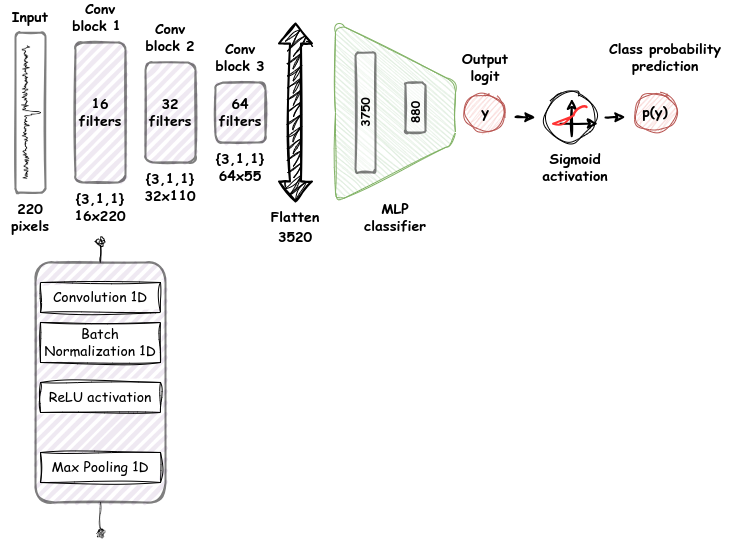

In [10]:
# Architecture
class line_modelv1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),)
            ####################################
        self.block2 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),)

            ####################################
        self.block3 = nn.Sequential(
            nn.Conv1d(hidden_units*2, hidden_units*4, 3, padding=1),
            nn.BatchNorm1d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),)
            ####################################
        self. flatten = nn.Flatten()
            ####################################
        self.classifier= nn.Sequential(
            nn.Linear(in_features= hidden_units*4*55, out_features= hidden_units*55),
            nn.Linear(in_features= hidden_units*55, out_features= output_shape),     
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = torch.sigmoid(self.classifier(x))
        return x


In [48]:
# shapes testing:
#model = line_modelv1(1,16,1)
#x = torch.randn(5,1,220)
#model(x)

### **III.  Defining an instance of this architecture and setting the loss function & the optimizer:**
* device --> ``cpu or gpu`` check runtime type!
* name --> ``model1``
* loss --> ``Binary corss entropy Loss``
* optimizer --> ``Adam``


In [381]:
torch.manual_seed(42)
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# creating an instance of the above defined model named model1:
model1 = line_modelv1(1, 16, 1).to(device)

model1

line_modelv1(
  (block1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=3520, out_features=880, bias=True)
    (1): Linear(in_features=880, out_features=1, bias=True)
  )
)

In [12]:
def train(model, n_epochs, train_loader, test_loader, val_loader, lr):
  # Setup loss and optimizer

  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(params= model.parameters(),lr=lr)

  history = {'train_loss': [],'test_loss':[], 'val_loss': [], 'train_acc': [],'test_acc':[], 'val_acc': []}
  for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
          
    for batch in train_loader:
      lines = batch['line']
      labels = batch['label']
      optimizer.zero_grad()
      outputs = model(lines)
      loss = loss_fn(outputs.squeeze(dim=1), labels.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * lines.size(0)
      preds = (outputs > 0.5).float()
      correct_train += (preds.squeeze(dim=1) == labels.float()).sum().item()
      total_train += labels.float().size(0)
      #print(total_train)
          
      train_loss = train_loss / total_train
      train_accuracy = correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
          
    with torch.no_grad():
      # Evaluate on validation set
      model.eval()
      test_loss = 0.0
      correct_test = 0.0
      total_test = 0
      for batch in test_loader:
        lines = batch['line']
        labels = batch['label']
        outputs = model(lines)
        loss = loss_fn(outputs.squeeze(dim=1), labels.float())
        test_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct_test += (preds.squeeze(dim=1) == labels.float()).sum().item()
        total_test += labels.float().size(0)
            
        test_loss = test_loss / total_test
        test_accuracy = correct_test / total_test
      history['test_loss'].append(test_loss)
      history['test_acc'].append(test_accuracy)
    
    if val_loader is not None:
      with torch.no_grad():
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct_val = 0.0
        total_val = 0
        for batch in val_loader:
          lines = batch['line']
          labels = batch['label']
          outputs = model(lines)
          loss = loss_fn(outputs.squeeze(dim=1), labels.float())
          val_loss += loss.item() * labels.size(0)
          preds = (outputs > 0.5).float()
          correct_val += (preds.squeeze(dim=1) == labels.float()).sum().item()
          total_val += labels.float().size(0)
              
          val_loss = val_loss / total_val
          val_accuracy = correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)
            
    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.7f}, Train Acc: {train_accuracy:.7f}, Test Loss: {test_loss:.7f}, Test Acc: {test_accuracy:.7f}')
      
  return history

### **V.  Training and testing:**


In [382]:
# expr3 --> 11 epochs; expr2 --> 15 expr1 --> 6 epochs # optimal number of epochs for each experiment (lowest testing loss point)
history = train (model1, 11, COMBtrain_loader, COMBtest_loader, val_loader = None, lr= 1e-4 )

Epoch [1/11], Train Loss: 0.0005999, Train Acc: 0.7903301, Test Loss: 0.0004772, Test Acc: 0.8217270
Epoch [2/11], Train Loss: 0.0000312, Train Acc: 0.8679684, Test Loss: 0.0001805, Test Acc: 0.8774373
Epoch [3/11], Train Loss: 0.0000172, Train Acc: 0.9065551, Test Loss: 0.0000191, Test Acc: 0.8816156
Epoch [4/11], Train Loss: 0.0003777, Train Acc: 0.9246862, Test Loss: 0.0012383, Test Acc: 0.8565460
Epoch [5/11], Train Loss: 0.0000061, Train Acc: 0.9316597, Test Loss: 0.0018050, Test Acc: 0.8830084
Epoch [6/11], Train Loss: 0.0002362, Train Acc: 0.9521153, Test Loss: 0.0006360, Test Acc: 0.8927577
Epoch [7/11], Train Loss: 0.0000018, Train Acc: 0.9525802, Test Loss: 0.0001188, Test Acc: 0.8927577
Epoch [8/11], Train Loss: 0.0000010, Train Acc: 0.9702464, Test Loss: 0.0039155, Test Acc: 0.8314763
Epoch [9/11], Train Loss: 0.0002491, Train Acc: 0.9665272, Test Loss: 0.0000206, Test Acc: 0.8830084
Epoch [10/11], Train Loss: 0.0000000, Train Acc: 0.9674570, Test Loss: 0.0000202, Test Acc:

### **VI.  Metrics & evaluation:**
* Training loss and testing loss as f(epoch).
* Confusion matrix.


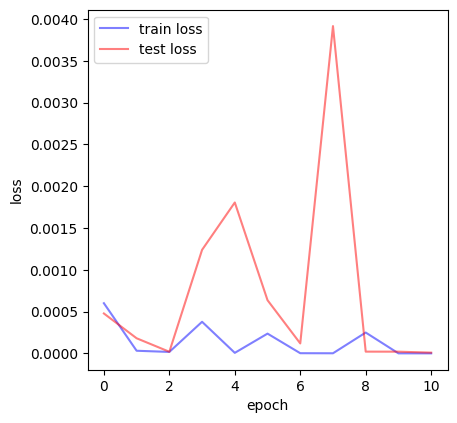

In [383]:
## loss curves:
trainl = history['train_loss']  #+ train_loss2
testl  = history['test_loss']
N = len(history['test_loss']) # number of epochs
fig = plt.figure(figsize=(4,4))
ax  = fig.add_axes ((0.1,0.1,0.9,0.9))

#train loss:
ax.plot(np.array(trainl), color='blue', alpha=0.5, label='train loss')
#test loss:
ax.plot( np.array(testl), color='red', alpha=0.5, label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend();

### **Checking predictions:**

In [400]:
y_pred_probs, y_pred, y_true, x_data, snr, mags = [], [], [], [], [], []

with torch.inference_mode():
  for batch in COMBval_loader: # here you can change the data_loader  ()
      X = batch['line']
      t = batch['label']
      snr.append(batch['meta'][:, 3])
      mags.append(batch['meta'][:, 5])
      y_pred_probs.append(model1(X).squeeze(dim=1))
      y_pred.append((model1(X).squeeze(dim=1)>0.5).float())
      y_true.append(t)
      x_data.append(X)

BATCH_SIZE = 5
probs       = torch.cat(y_pred_probs)
predictions = torch.cat(y_pred)
truth       = torch.cat(y_true)
data        = torch.cat(x_data)
snr         = torch.cat(snr)
mags        = torch.cat(mags)

# mags has some nans in it and outliers (non physical values; ex: 99.), these two lines will remove nans and non-physical values
mag_mask =(np.isnan(mags) == 0) * (mags < 35)
mags[mag_mask]


### **Confusion matrix, and model confidence outputs plots:**

/tmp/ipykernel_692655/2915578140.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target= torch.tensor(truth))


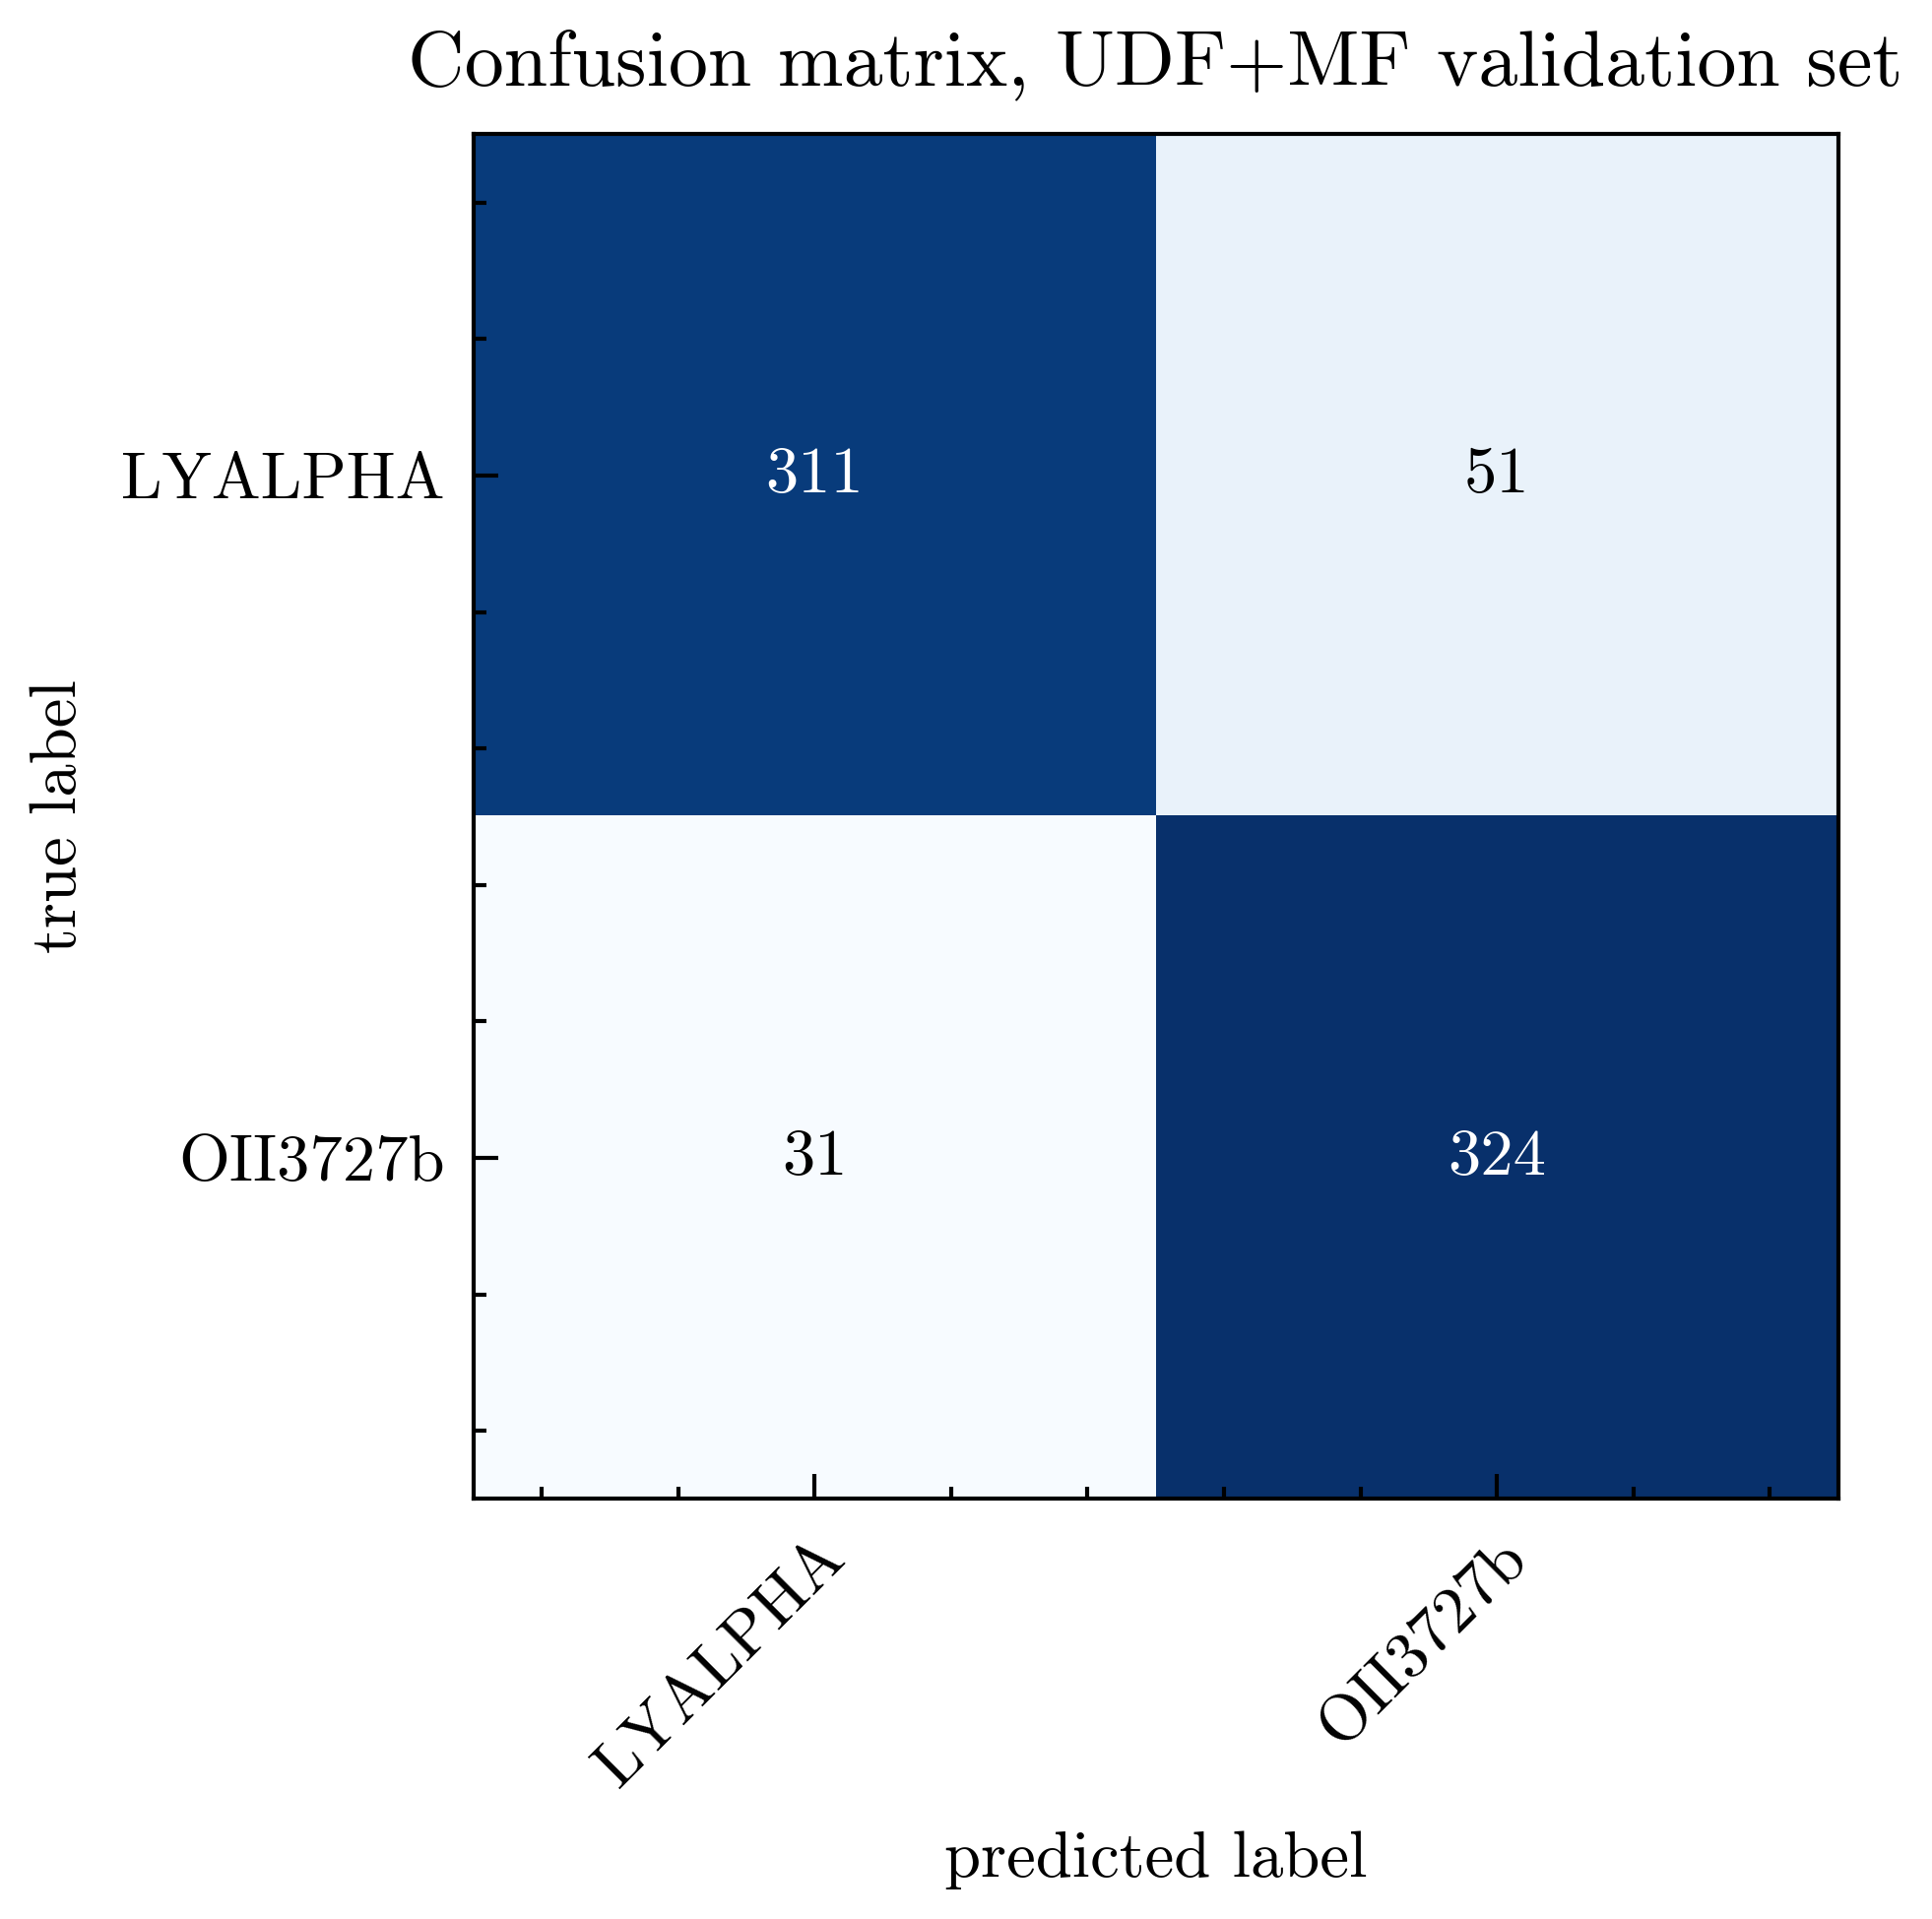

In [403]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds= predictions,
                         target= torch.tensor(truth))

# 3. Plot the confusion matrix
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig1, ax1 = plot_confusion_matrix(
            conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
            class_names=class_names, # turn the row and column labels into class names
            figsize=(4, 3)
        );

    ax1.set_title('Confusion matrix, UDF+MF validation set')
    plt.show()

ax.tick_params(axis='x', labelsize=12, labelcolor='k', labelrotation=45)  
ax.tick_params(axis='y', labelsize=12, labelcolor='k')   
ax.spines['bottom'].set_linewidth(2)  # Adjust the width of the bottom spine
ax.spines['left'].set_linewidth(2) 
ax.spines['top'].set_linewidth(2)  # Adjust the width of the bottom spine
ax.spines['right'].set_linewidth(2) 
  
plt.show()

#### Prob distrtibution for misclassification:

In [405]:
misclass_lya, misclass_oii, mis_lya_idices, mis_oii_idices = [], [], [], []

for i,y,t,p in zip(np.arange(probs.shape[0]),predictions, truth, probs):
  if np.logical_and(y != t, t == 0):
    misclass_lya.append(p)
    mis_lya_idices.append(i)
  if np.logical_and(y != t, t == 1):
    misclass_oii.append(p)
    mis_oii_idices.append(i)

gclass_lya, gclass_oii = [], []

for i,y,t,p in zip(np.arange(probs.shape[0]),predictions, truth, probs):
  if np.logical_and(y == t, t == 0):
    gclass_lya.append(p)
  if np.logical_and(y == t,t == 1):
    gclass_oii.append(p)

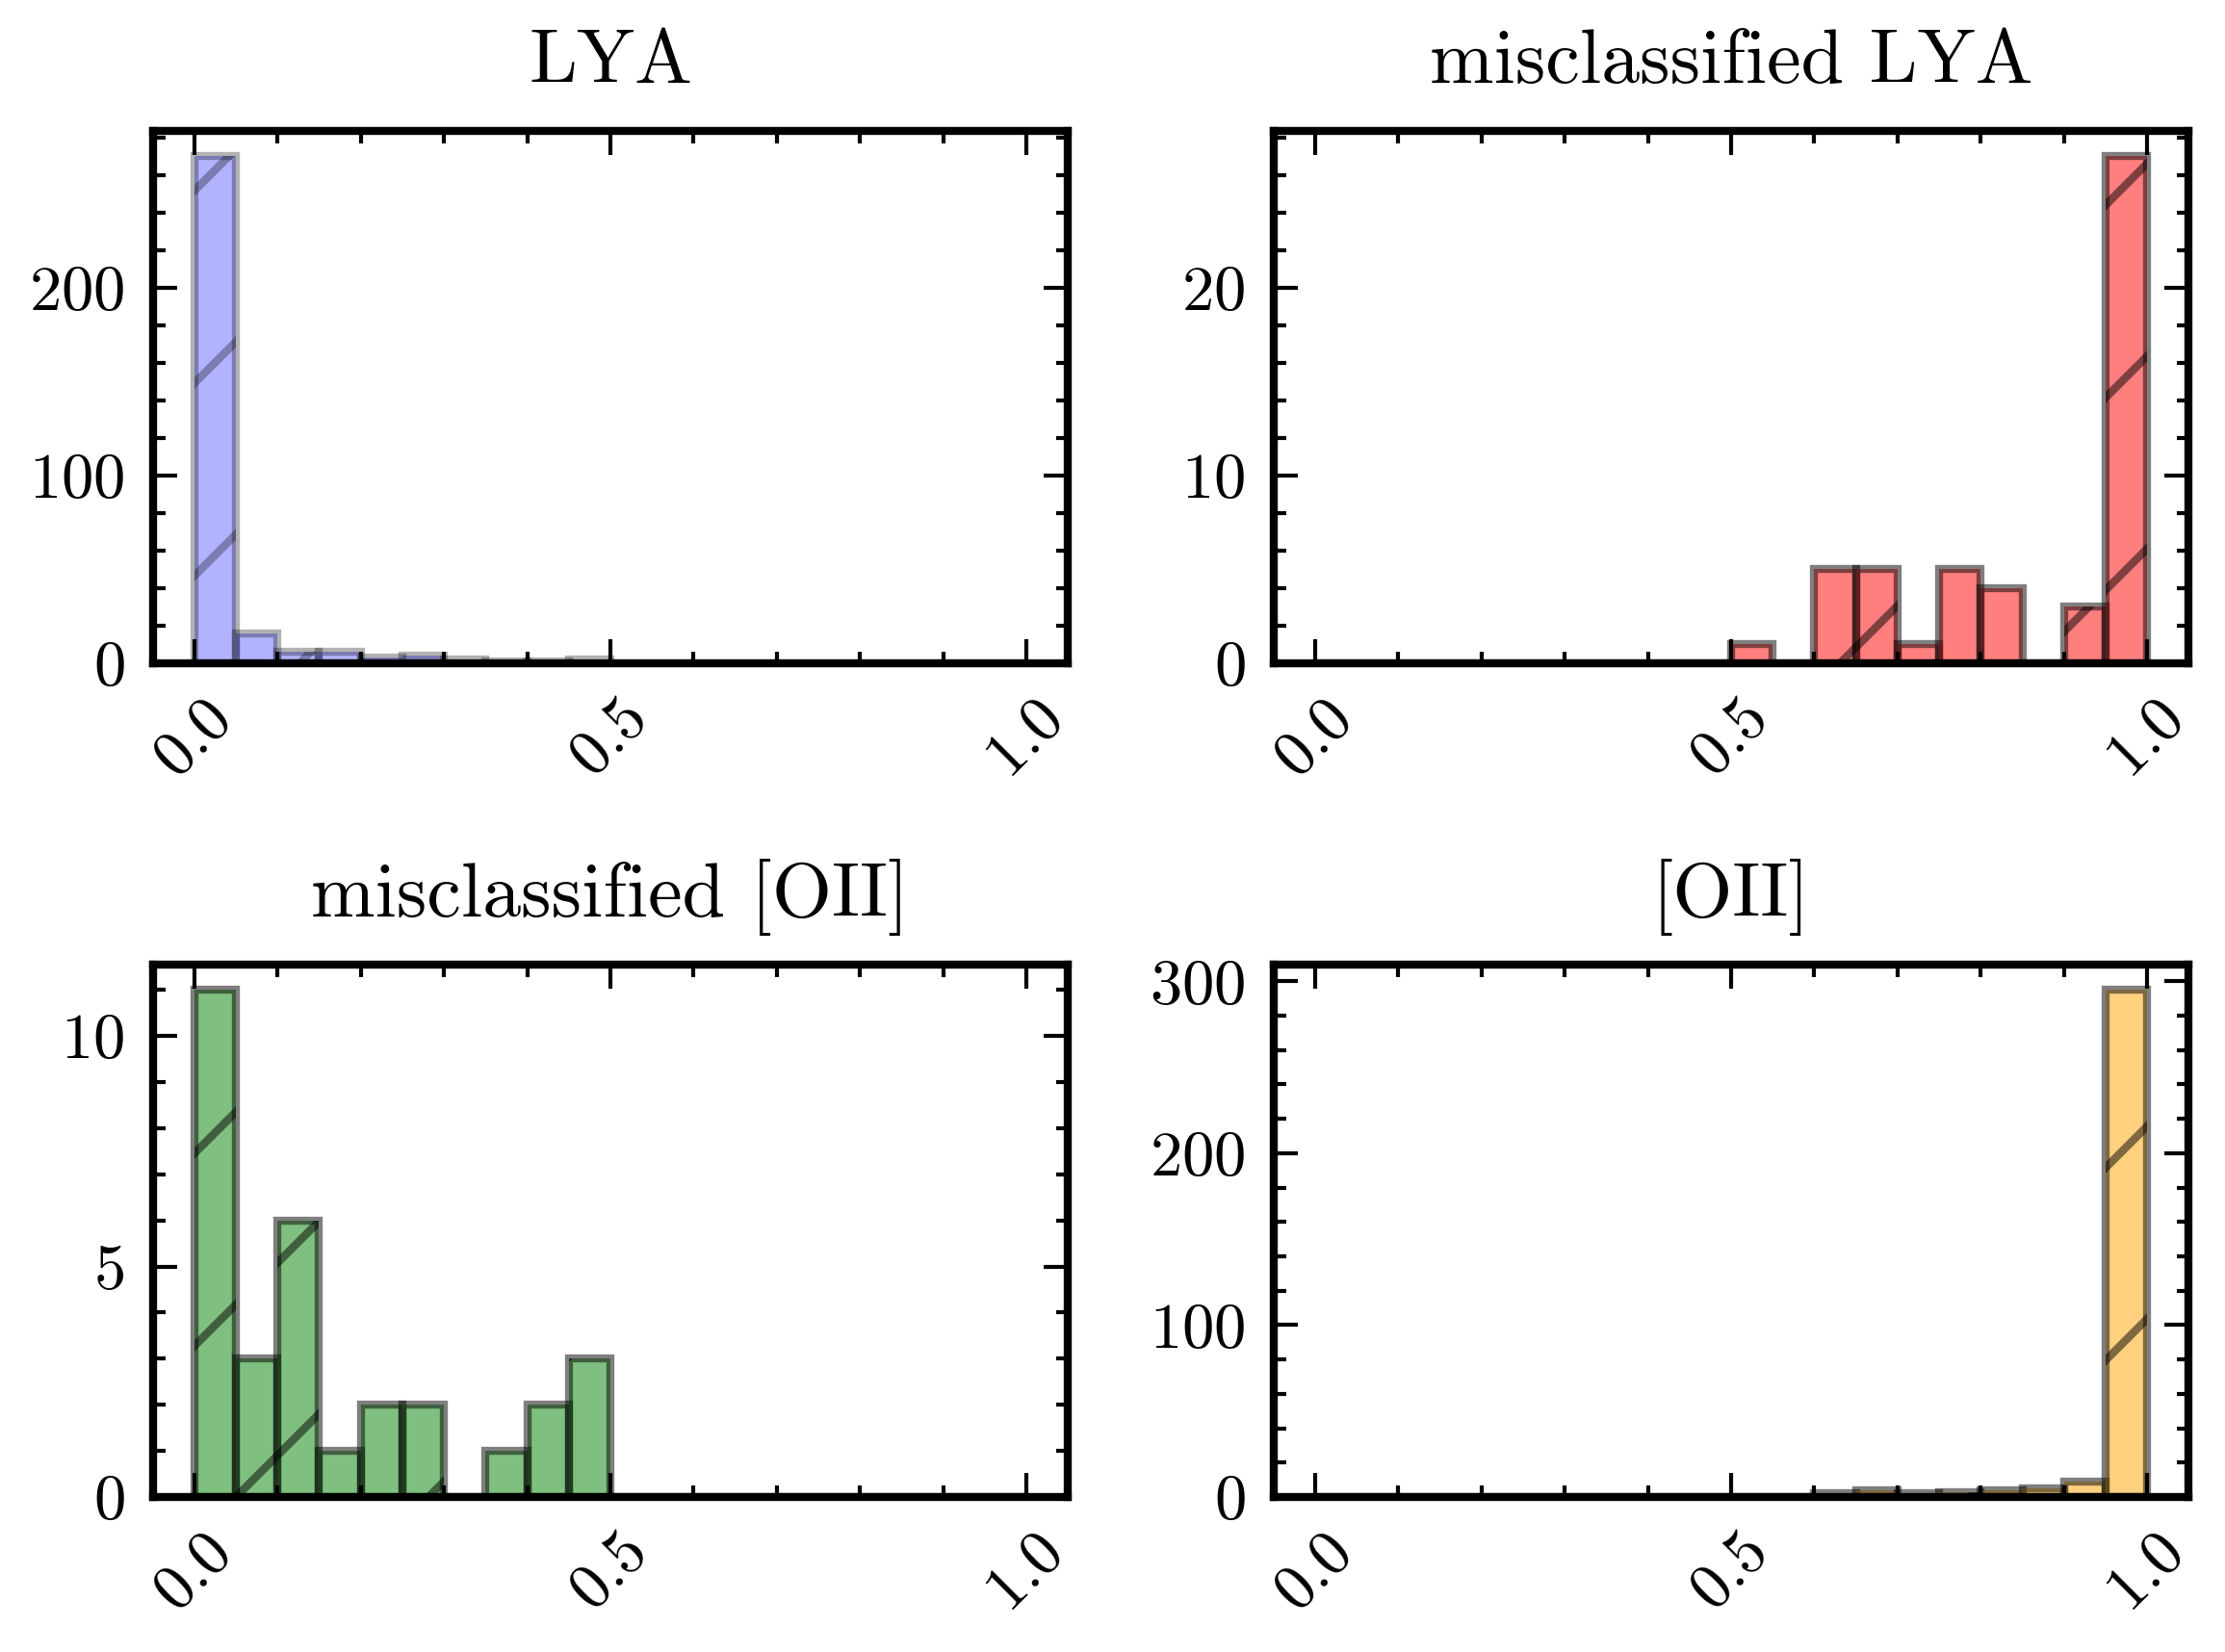

In [406]:
# Create a figure and subplots
with plt.style.context(['science', 'ieee', 'no-latex']):
  fig, axs = plt.subplots(2, 2, figsize= (4,3))
  bins = 20
  # Plot histograms in each subplot
  axs[0, 0].hist(gclass_lya, bins, range=(0,1), edgecolor='black', alpha=0.3,hatch='/', color='blue')
  axs[0, 0].set_title('LYA')

  axs[0, 1].hist(misclass_lya, bins,range=(0,1),edgecolor='black',alpha =0.5,hatch='/', color='red')
  axs[0, 1].set_title('misclassified LYA')

  axs[1, 0].hist(misclass_oii, bins,range=(0,1), alpha =0.5, edgecolor='black',hatch='/', color='green')
  axs[1, 0].set_title('misclassified [OII]')

  axs[1, 1].hist(gclass_oii, bins,range=(0,1), alpha=0.5, edgecolor='black',hatch='/', color='orange')
  axs[1, 1].set_title('[OII]')

  for i in [0,1]:
    for j in [0,1]:
      axs[i,j].tick_params(axis='x', labelsize=8, labelcolor='k', labelrotation=45)  
      axs[i,j].tick_params(axis='y', labelsize=8, labelcolor='k')   
      axs[i,j].spines['bottom'].set_linewidth(1)  # Adjust the width of the bottom spine
      axs[i,j].spines['left'].set_linewidth(1) 
      axs[i,j].spines['top'].set_linewidth(1)  # Adjust the width of the bottom spine
      axs[i,j].spines['right'].set_linewidth(1) 
    # Adjust layout70 batches of 5
  plt.tight_layout()

  # Show the plot
  plt.show()


### **Other metrics: (f1 score and completeness)**

In [407]:
def rates(y_true, y_pred):
  TP, FP, TN, FN = 0, 0, 0, 0
  for pred, true in zip(y_pred, y_true):
    if np.logical_and(true==1, pred==1): TP += 1
    if np.logical_and(true==1., pred==0.): FP += 1
    if np.logical_and(true==0., pred==0.): TN += 1
    if np.logical_and(true==0., pred==1.): FN += 1

  print(TP,FP, FN, TN)

  P = TP/(TP+FP)
  C = TP/(TP+FN)
  print(P,C)
  F1 = 2*((P*C)/(P+C))

  return P,C,F1

In [408]:
# bin edges based on SNR
num_bins = 8
# Calculate the bin edges based on the distribution of SNR
bin_edges1 = np.percentile(snr, np.linspace(0, 100, num_bins + 1)).tolist()  # --> bin_edges1 for SNR
bin_edges =np.linspace(mags[mag_mask].min(), mags[mag_mask].max(), num_bins + 1) # --> bin edges is for mags

In [411]:
# binning the data:

# Find the bin indices based on SNR
bin_indices1 = np.digitize(snr, bin_edges1)# Adjust the bin edges as needed
bin_indices = np.digitize(mags[mag_mask], bin_edges)# Adjust the bin edges as needed

# Group x and y based on the bin indices
binned_pred = [predictions[mag_mask][bin_indices == i] for i in range(1, len(bin_edges1))]
binned_truth = [truth[mag_mask][bin_indices == i] for i in range(1, len(bin_edges1))]

binned_pred1 = [predictions[bin_indices1 == i] for i in range(1, len(bin_edges1))]
binned_truth1 = [truth[bin_indices1 == i] for i in range(1, len(bin_edges1))]

In [ ]:
# Display the binned data
#for i in range(len(bin_edges) - 1):
#    print(f"Bin {i+1}:")
#    print("x:", binned_pred[i])
#    print("y:", binned_truth[i])


Bin 1:
x: tensor([1., 1., 1., 1.])
y: tensor([1, 1, 1, 1])
Bin 2:
x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
y: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
Bin 3:
x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])
y: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
Bin 4:
x: tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1

#### metrics vs magnitude:

In [416]:
#F1 score
f1_scores, cmpl_scores, pur_scores = [], [], []
for i in range(len(bin_edges) - 1):
  y_true = binned_truth[i]
  y_pred = binned_pred[i]

  P,C, F1 = rates (y_true, y_pred)

  f1_scores.append(F1)
  cmpl_scores.append(C)
  pur_scores.append(P)

  print("F1 Score:", F1)
  print("Completeness Score:", C)
  print("Purity Score:", P)

# some metrics are not defined for the last bin
# 

39 17 6 28
0.6964285714285714 0.8666666666666667
F1 Score: 0.7722772277227722
Completeness Score: 0.8666666666666667
Purity Score: 0.6964285714285714
21 7 12 49
0.75 0.6363636363636364
F1 Score: 0.6885245901639345
Completeness Score: 0.6363636363636364
Purity Score: 0.75
31 3 8 48
0.9117647058823529 0.7948717948717948
F1 Score: 0.8493150684931507
Completeness Score: 0.7948717948717948
Purity Score: 0.9117647058823529
29 3 7 50
0.90625 0.8055555555555556
F1 Score: 0.8529411764705882
Completeness Score: 0.8055555555555556
Purity Score: 0.90625
44 0 6 40
1.0 0.88
F1 Score: 0.9361702127659575
Completeness Score: 0.88
Purity Score: 1.0
43 1 5 40
0.9772727272727273 0.8958333333333334
F1 Score: 0.9347826086956522
Completeness Score: 0.8958333333333334
Purity Score: 0.9772727272727273
57 0 4 29
1.0 0.9344262295081968
F1 Score: 0.9661016949152543
Completeness Score: 0.9344262295081968
Purity Score: 1.0
60 0 3 26
1.0 0.9523809523809523
F1 Score: 0.975609756097561
Completeness Score: 0.9523809523

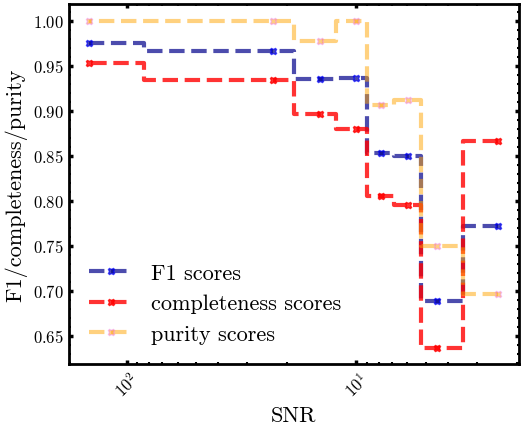

In [417]:
# plotting:
with plt.style.context(['science', 'ieee', 'no-latex']):
  fig = plt.figure(figsize=(5,4), dpi = 100)
  ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
  bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]

  ax.step(bin_centers[:-1], f1_scores,where='mid', linestyle='--',color='darkblue', alpha = 0.7,linewidth= 3, label = 'F1 scores',  marker='X', markeredgecolor='blue', markeredgewidth=1, markersize=5);
  ax.step(bin_centers[:-1], cmpl_scores,where='mid', linestyle='--',alpha = 0.8,color='red',linewidth= 3, label = 'completeness scores',  marker='X', markeredgecolor='red', markeredgewidth=1, markersize=5);
  ax.step(bin_centers[:-1], pur_scores,where='mid', linestyle='--',color = 'orange', alpha = 0.5,linewidth= 3, label = 'purity scores',  marker='X', markeredgecolor='violet', markeredgewidth=1, markersize=5);
  # [:-1] because some metrics are not defined for the last bin
  ax.invert_xaxis()
  
  ax.tick_params(axis='x', labelsize=12, labelcolor='k', labelrotation=45)  
  ax.tick_params(axis='y', labelsize=12, labelcolor='k')   
  ax.spines['bottom'].set_linewidth(2)  # Adjust the width of the bottom spine
  ax.spines['left'].set_linewidth(2) 
  ax.spines['top'].set_linewidth(2)  # Adjust the width of the bottom spine
  ax.spines['right'].set_linewidth(2) 
  ax.tick_params(axis='both', which='major', width=2.5)  # Increase the thickness
  ax.tick_params(axis='both', which='minor', width=1.5)
  
  ax.set_xlabel('MAG F775W', fontsize = 16)

  ax.set_ylabel('F1/completeness/purity', fontsize = 16)
  legend = ax.legend(fontsize = 16)

  for text in legend.get_texts():
    text.set_weight('bold')
  plt.show()

#### metrics vs SNR:

In [69]:
#F1 score
f1_scores, cmpl_scores, pur_scores = [], [], []
for i in range(len(bin_edges1) - 1):
  y_true = binned_truth1[i]
  y_pred = binned_pred1[i]

  P,C, F1 = rates (y_true, y_pred)

  f1_scores.append(F1)
  cmpl_scores.append(C)
  pur_scores.append(P)

  print("F1 Score:", F1)
  print("Completeness Score:", C)
  print("Purity Score:", P)


F1 Score: 0.6666666666666666
Completeness Score: 0.4276484429651058
Purity Score: 0.7455645324887386
F1 Score: 0.5
Completeness Score: 0.2467174310733695
Purity Score: 0.2467174310733695
F1 Score: 0.7
Completeness Score: 0.37808665941603536
Purity Score: 0.4933817697614
F1 Score: 0.7924528301886793
Completeness Score: 0.4327407495406051
Purity Score: 0.4965028081958337
F1 Score: 0.9009009009009009
Completeness Score: 0.41291232382239995
Purity Score: 0.4176960497949535
F1 Score: 0.9197080291970803
Completeness Score: 0.29470035818835927
Purity Score: 0.37586610310421037
F1 Score: 0.9290322580645162
Completeness Score: 0.10709515311726038
Purity Score: 0.41097337275069457
F1 Score: 0.881578947368421
Completeness Score: 0.005281096491001641
Purity Score: 0.041316489403958274


In [ ]:
# plotting:
with plt.style.context(['science', 'ieee', 'no-latex']):
  fig = plt.figure(figsize=(5,4), dpi = 100)
  ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
  bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]

  #ax.hist(f1_scores, bins = bin_edges, edgecolor='black',alpha =0.6, color='blue', label = 'F1 scores');
  ax.step(bin_centers[:], f1_scores,where='mid', linestyle='--',color='darkblue', alpha = 0.7,linewidth= 3, label = 'F1 scores',  marker='X', markeredgecolor='blue', markeredgewidth=1, markersize=5);
  ax.step(bin_centers[:], cmpl_scores,where='mid', linestyle='--',alpha = 0.8,color='red',linewidth= 3, label = 'completeness scores',  marker='X', markeredgecolor='red', markeredgewidth=1, markersize=5);
  ax.step(bin_centers[:], pur_scores,where='mid', linestyle='--',color = 'orange', alpha = 0.5,linewidth= 3, label = 'purity scores',  marker='X', markeredgecolor='violet', markeredgewidth=1, markersize=5);
  ax.set_xscale('log')
  
  ax.tick_params(axis='x', labelsize=12, labelcolor='k', labelrotation=45)  
  ax.tick_params(axis='y', labelsize=12, labelcolor='k')   
  ax.spines['bottom'].set_linewidth(2)  # Adjust the width of the bottom spine
  ax.spines['left'].set_linewidth(2) 
  ax.spines['top'].set_linewidth(2)  # Adjust the width of the bottom spine
  ax.spines['right'].set_linewidth(2) 
  ax.tick_params(axis='both', which='major', width=2.5)  # Increase the thickness
  ax.tick_params(axis='both', which='minor', width=1.5)
  
  ax.set_xlabel('SNR', fontsize = 16)

  ax.set_ylabel('F1/completeness/purity', fontsize = 16)
  legend = ax.legend(fontsize = 16)

  for text in legend.get_texts():
    text.set_weight('bold')
  plt.show()